# smFISH analysis

This notebook walks through the proposed workflow for analyzing smFISH with starfish

To do:
* add image download
* change dataset to 16 bit

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

from starfish.io import Stack
from starfish.constants import Indices
from starfish.codebook import Codebook

In [1]:
experiment_json = '../ParamSearch/output/experiment.json'

In [4]:
codebook = Codebook.from_json('../ParamSearch/output/codebook_new.json')
codebook

<xarray.Codebook (gene_name: 1, c: 1, h: 1)>
array([[[1]]], dtype=uint8)
Coordinates:
  * gene_name  (gene_name) object 'GAPDH'
  * c          (c) int64 0
  * h          (h) int64 0

We're ready now to load the experiment into starfish (This experiment is big, it takes a few minutes):

uint16


<IPython.core.display.Javascript object>


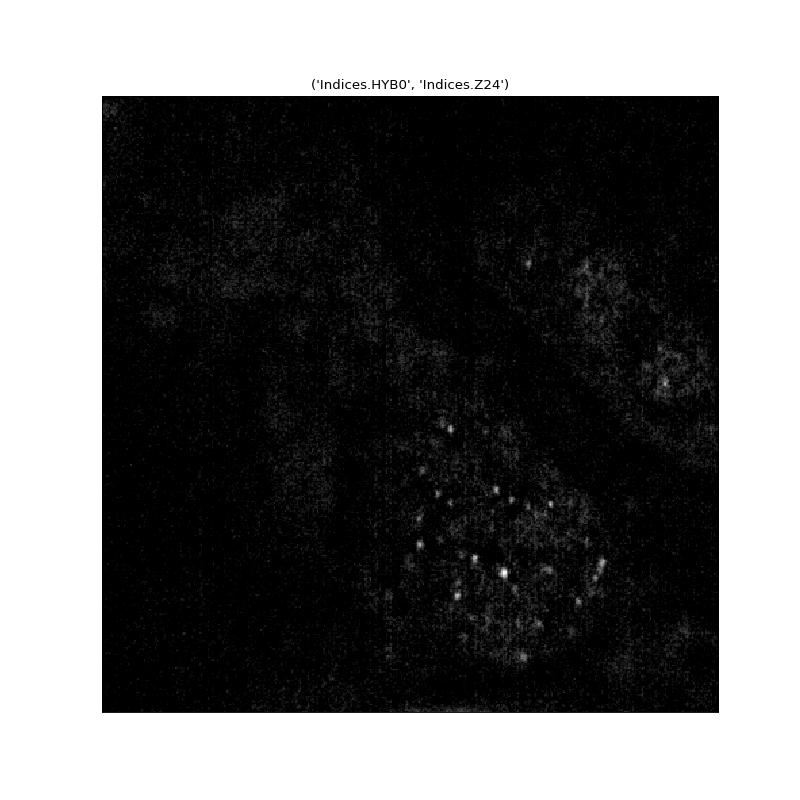

interactive(children=(IntSlider(value=25, description='plane_index', max=50), Output()), _dom_classes=('widget-interact',))

In [5]:
s = Stack()
s.read(experiment_json)

# In place convert to uint16
s.image.numpy_array = s.image.numpy_array.astype(np.uint16);

print(s.image.numpy_array.dtype)

s.image.show_stack({Indices.CH: 0});

In [8]:
from starfish.pipeline.filter.mean_high_pass import MeanHighPass

s_mhp = MeanHighPass(size=6)

s_mhp.filter(s.image)

s.image.show_stack({Indices.CH: 0});

interactive(children=(IntSlider(value=0, description='plane_index', max=50), Output()), _dom_classes=('widget-interact',))

In [6]:
from starfish.pipeline.filter.gaussian_low_pass import GaussianLowPass

sigma=(2, 1, 1)

glp = GaussianLowPass(sigma=sigma, is_volume=True)
glp.filter(s.image)

s.image.show_stack({Indices.CH: 0});

interactive(children=(IntSlider(value=0, description='plane_index', max=50), Output()), _dom_classes=('widget-interact',))

In [7]:
from starfish.pipeline.features.spots.detector.gaussian import GaussianSpotDetector
import warnings

# parameters to define the allowable gaussian sizes (parameter space)
min_sigma = 1
max_sigma = 10
num_sigma = 30
threshold = 0.01

p = GaussianSpotDetector(
    min_sigma=min_sigma,
    max_sigma=max_sigma,
    num_sigma=num_sigma,
    threshold=threshold,
    blobs_stack=s.image,
    measurement_type='mean',
)

# detect triggers some numpy warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # blobs = dots; define the spots in the dots image, but then find them again in the stack.
    intensities = p.find(s.image)
    
print(intensities.shape[0])

91


In [8]:
intensities[0]

<xarray.IntensityTable (c: 1, h: 1)>
array([[738.763889]])
Coordinates:
    features  object (35, 426, 375, 3, 32, 38, 423, 429, 372, 378, 738.7638888888889, 0) ...
  * c         (c) int64 0
  * h         (h) int64 0

In [9]:
decoded = codebook.decode_per_hyb_max(intensities)

decoded

<xarray.IntensityTable (features: 91, c: 1, h: 1)>
array([[[ 738.763889]],

       [[ 751.416667]],

       [[ 552.680556]],

       [[1157.75    ]],

       [[ 898.435185]],

       [[1087.859375]],

       [[ 627.291667]],

       [[ 572.583333]],

       [[ 766.6875  ]],

       [[ 585.49537 ]],

       [[ 636.949074]],

       [[ 787.734375]],

       [[ 560.273148]],

       [[ 634.00463 ]],

       [[ 530.689815]],

       [[ 646.726852]],

       [[ 631.435185]],

       [[ 634.458333]],

       [[1065.328125]],

       [[1104.546875]],

       [[ 580.199074]],

       [[ 745.25    ]],

       [[ 841.296296]],

       [[ 598.236111]],

       [[ 663.171296]],

       [[ 560.944444]],

       [[1040.574074]],

       [[ 551.564815]],

       [[ 562.921296]],

       [[ 536.157407]],

       [[ 529.800926]],

       [[ 548.203704]],

       [[ 932.203125]],

       [[ 728.513889]],

       [[ 941.296875]],

       [[ 603.986111]],

       [[ 672.125   ]],

       [[ 764.685185]],


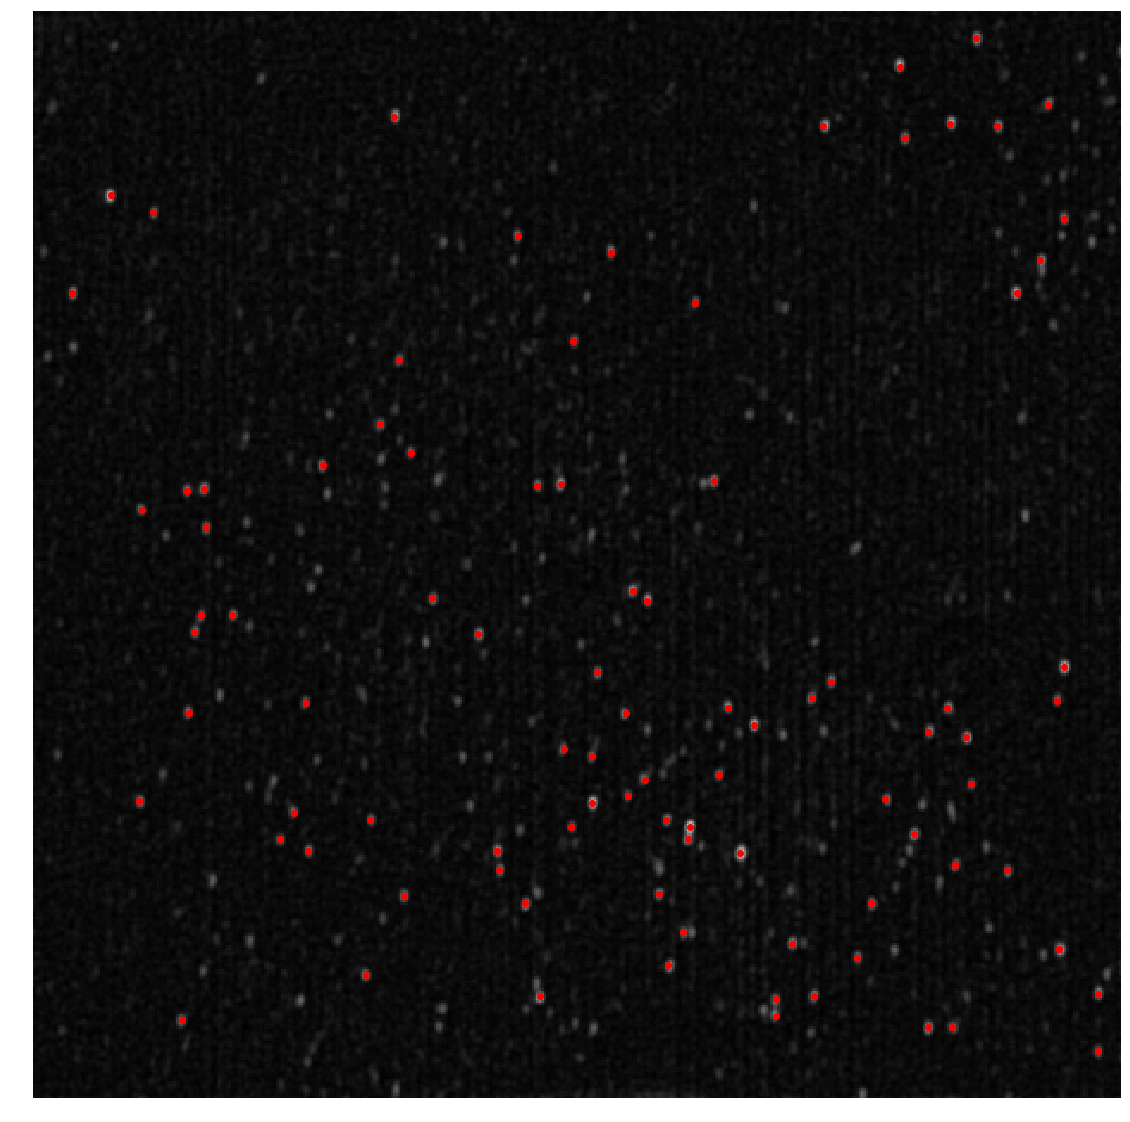

In [11]:
from showit import image

GENE1 = 'GAPDH'

# Plot a MIP of the image
ch1 = s.image.max_proj(Indices.Z)[0][0]
image(ch1, size=20);

# Overlay the detected spots
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)
    is_gene1 = decoded.where(decoded.gene_name == GENE1, drop=True)

plt.plot(is_gene1.x, is_gene1.y, 'or');

